In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# the binary entropy
def H(p):
    return np.nan_to_num(-p*(np.log(p)/np.log(2))-(1-p)*(np.log(1-p)/np.log(2)))

In [3]:
#####################
# inverse of the binary entropy
def H_inverse(q):
    p_0=0
    p_1=0.5
    for i in range(0,60):
        p=(p_0+p_1)/2
        if H(p)<q:
            p_0=p
        else:
            p_1=p
    return p_1

In [4]:
# I(X_r; Y_BSC) - I(X_r; Y_BEC)
def mut_inf(q, p, r):
    conv = r*(1-p)+(1-r)*p
    return H(conv)-H(p)-(1-q)*H(r)

In [5]:
# return -min_r mut_inf(q, p, r); compute by ternary search
def find_eta(q, p):
    left = 0
    right = 0.5
    TRIES = 150
    for i in range(TRIES):
        m1 = (2*left+right)/3
        m2 = (left+2*right)/3
        val1 = -mut_inf(q, p, m1)
        val2 = -mut_inf(q, p, m2)
        if val1 < val2:
            left = m1
        else:
            right = m2
    return -mut_inf(q, p, left)

In [6]:
# h(p)=q
R = np.linspace(0, 1, 100)
Q = 1-R
P, ETA = np.zeros_like(Q), np.zeros_like(Q)
for i in range(len(Q)):
    q = Q[i]
    p = H_inverse(q)
    P[i] = p
    ETA[i] = find_eta(q, p)

### $h(p) = 2q$, $h(p) = q/2$

In [7]:
# h(p) = 2q, q = 0..0.5
R2 = np.linspace(0.5, 1, 100)
Q2 = 1-R2
P2, ETA2 = np.zeros_like(Q2), np.zeros_like(Q2)
for i in range(len(Q2)):
    q = Q2[i]
    p = H_inverse(2*q)
    P2[i] = p
    ETA2[i] = find_eta(q, p)

In [8]:
# h(p) = q/2
P_HALF, ETA_HALF = np.zeros_like(Q), np.zeros_like(Q)
for i in range(len(Q)):
    q = Q[i]
    p = H_inverse(q/2)
    P_HALF[i] = p
    ETA_HALF[i] = find_eta(q, p)

In [9]:
# h(p) = 3q/4
P_34, ETA_34 = np.zeros_like(Q), np.zeros_like(Q)
for i in range(len(Q)):
    q = Q[i]
    p = H_inverse(3*q/4)
    P_34[i] = p
    ETA_34[i] = find_eta(q, p)

### Rao-Sprumont

In [10]:
# RAO SPRUMONT: log L / N = max( p*log(2/(1-R)), 4*p )
RS = np.maximum( P*np.log2( 2/(1-R) ), 4*P )
RS[-1] = 0  # lim_{R --> 1} P*log(2/1-R) = 0

For $R\approx 1$ we have $p = h^{-1}(q)\sim \frac{q}{\log_2 1/q}$. So, the RS bound is
$\frac{q}{\log_2 1/q}\cdot\log_2(2/q)\sim q$.

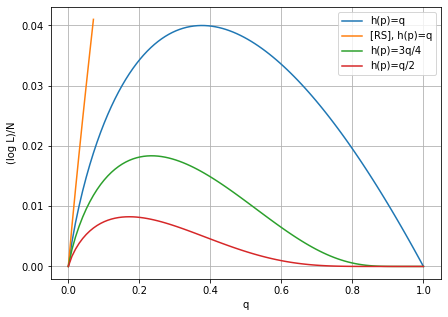

In [12]:
plt.figure(figsize=(7,5))
plt.xlabel('q')
plt.ylabel('(log L)/N')
plt.plot(Q, ETA, label='h(p)=q')

Qprim, RSprim = zip(*[(q, rs) for (q, rs) in zip(Q, RS) if rs <= 0.045])

plt.plot(Qprim, RSprim, label='[RS], h(p)=q')

plt.plot(Q, ETA_34, label='h(p)=3q/4')
plt.plot(Q, ETA_HALF, label='h(p)=q/2')

#plt.plot(R, 1-H_GERBER, label='norm_2')
plt.grid()
plt.legend()
# plt.savefig('equal_capacity')
# plt.savefig("equal_capacity2.pdf", format="pdf", bbox_inches="tight")

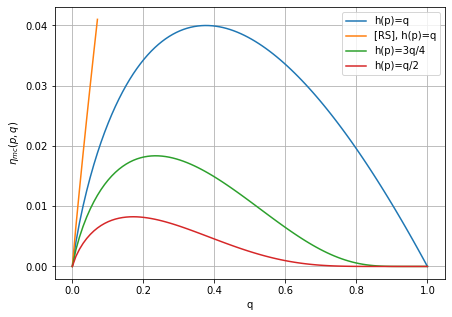

In [13]:
plt.figure(figsize=(7,5))
plt.xlabel('q')
plt.ylabel('$\eta_{mc}(p,q)$')
plt.plot(Q, ETA, label='h(p)=q')

Qprim, RSprim = zip(*[(q, rs) for (q, rs) in zip(Q, RS) if rs <= 0.045])

plt.plot(Qprim, RSprim, label='[RS], h(p)=q')

plt.plot(Q, ETA_34, label='h(p)=3q/4')
plt.plot(Q, ETA_HALF, label='h(p)=q/2')

#plt.plot(R, 1-H_GERBER, label='norm_2')
plt.legend()
plt.grid()
# plt.savefig('equal_capacity2')
# plt.savefig("equal_capacity2.pdf", format="pdf", bbox_inches="tight")

### 2-norm

A code achieving capacity on the BEC also decoding errors on the BSC for $p_{HSS}$.

That means that $H(Y_{HSS})/N \sim h(p_{HSS})+R$. Let $p_{conv}$ be such that $p_{HSS}*p_{conv}=p$.

By Mrs Gerber, $H(Y_p)/N \ge h( p_{conv}*h^{-1}(R+h(p_{HSS})))$.

Finally, $H(X|Y_p)/N=R+h(p)-H(Y_p)$.

In [14]:
def mrs_gerber(alpha, z):
    p = H_inverse(z)
    conv = p*(1-alpha)+(1-p)*alpha
    return H(conv)

In [15]:
def find_conv(p_start, p_fin):
    left = 0
    right = 0.5
    for i in range(60):
        mid = (left+right)/2
        val = p_start*(1-mid)+mid*(1-p_start)
        if val > p_fin:
            right = mid
        else:
            left = mid
    return left

In [16]:
# HSS q=0.5
p_hss = 0.5 - np.sqrt(2**(-0.5)*(1-2**(-0.5)))
print(p_hss, H(p_hss))

0.04491013943777267 0.2643688375379239


In [17]:
H_ARR = np.linspace(0, 1, 100)
ETA_GERBER = np.zeros_like(H_ARR)
for i in range(len(H_ARR)):
    h = H_ARR[i]
    p = H_inverse(h)
    if p <= p_hss:
        ETA_GERBER[i] = 0
        continue
    p_conv = find_conv(p_hss, p)
    h_gerber = mrs_gerber(p_conv, 0.5+H(p_hss))
    ETA_GERBER[i] = 0.5+h-h_gerber

$\eta$ as a function of $h(p)$ for $q=1/2$

In [18]:
ETA_MC = np.zeros_like(H_ARR)
for i in range(len(H_ARR)):
    h = H_ARR[i]
    p = H_inverse(h)
    eta = find_eta(0.5, p)
    ETA_MC[i] = eta

Plot

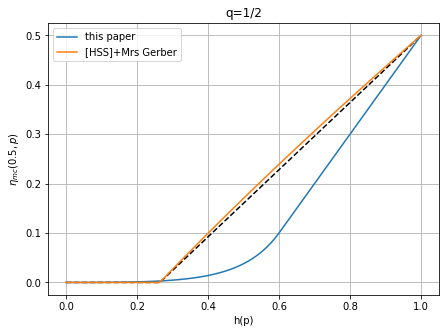

In [19]:
plt.figure(figsize=(7,5))
plt.plot(H_ARR, np.maximum(0, (H_ARR-H(p_hss))*0.5/(1-H(p_hss)) ), '--', color='black',)
plt.plot(H_ARR, ETA_MC, label='this paper')
plt.plot(H_ARR, ETA_GERBER, label='[HSS]+Mrs Gerber')
plt.ylabel("$\eta_{mc}(0.5, p)$")
plt.xlabel('h(p)')
plt.title('q=1/2')
plt.grid()
plt.legend()
plt.savefig("q_half2.pdf", format="pdf", bbox_inches="tight")
# plt.savefig('q_half')

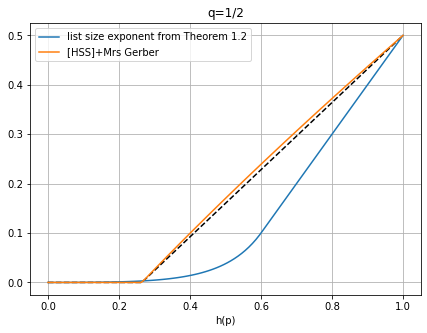

In [20]:
plt.figure(figsize=(7,5))
plt.plot(H_ARR, np.maximum(0, (H_ARR-H(p_hss))*0.5/(1-H(p_hss)) ), '--', color='black',)
plt.plot(H_ARR, ETA_MC, label='list size exponent from Theorem 1.2')
plt.plot(H_ARR, ETA_GERBER, label='[HSS]+Mrs Gerber')
plt.xlabel('h(p)')
plt.title('q=1/2')
plt.legend()
plt.grid()
plt.savefig("q_half2.pdf", format="pdf", bbox_inches="tight")
# plt.savefig('q_half2')